In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import numpy.random as npr
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-paper')
from matplotlib import cm
from zoneinfo import ZoneInfo
import itertools
import warnings
from functools import partial
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import pickle
import os

import nomad.io.base as loader
import nomad.stop_detection.utils as utils
import nomad.stop_detection.lachesis as LACHESIS
import nomad.stop_detection.ta_dbscan as TADBSCAN
import nomad.stop_detection.postprocessing as pp

import nomad.visit_attribution as visits
import nomad.city_gen as cg
import nomad.traj_gen as tg
import nomad.filters as filters
from nomad.traj_gen import Agent, Population

from nomad.contact_estimation import overlapping_visits, compute_visitation_errors, compute_precision_recall_f1
from metrics import poi_map, identify_stop, prepare_diary, prepare_stop_table, cluster_metrics

import pdb

In [3]:
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [4]:
def plot_sparse_clusters(
    sparse_traj,
    labels,
    ax,
    full_traj=None,
    buffer=None,              # 0‒1 → pad bbox by (1+buffer); None → no limits
    cmap=cm.tab20c
):
    n_clusters = int(labels[labels >= 0].max() + 1) if (labels >= 0).any() else 0
    for cid in range(n_clusters):
        m = labels == cid
        ax.scatter(sparse_traj.x[m], sparse_traj.y[m],
                   s=80, color=cmap(cid / (n_clusters + 1)),
                   zorder=2)
    ax.scatter(sparse_traj.x, sparse_traj.y, s=6, color='black', zorder=2)
    if full_traj is not None:
        ax.plot(full_traj.x, full_traj.y, lw=1.2, color='blue', alpha=0.2, zorder=1)
        if buffer is not None:
            x0, x1 = full_traj.x.min(), full_traj.x.max()
            y0, y1 = full_traj.y.min(), full_traj.y.max()
            pad_x = (x1 - x0) * buffer / 2
            pad_y = (y1 - y0) * buffer / 2
            ax.set_xlim(x0 - pad_x, x1 + pad_x)
            ax.set_ylim(y0 - pad_y, y1 + pad_y)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_aspect('equal', adjustable='box')
    plt.tight_layout()
    return ax

def classify_building_size_from_id(building_id):
    building = city.buildings.get(building_id)
    n_blocks = len(building.blocks)
    if n_blocks == 1:
        return 'small'
    elif 2 <= n_blocks <= 3:
        return 'medium'
    else:
        return 'big'

def classify_building_type_from_id(building_id):
    building = city.buildings.get(building_id)
    return building.building_type

def classify_dwell(duration):
    if duration <= 5:
        return 'low'
    elif 6 <= duration <= 120:
        return 'mid'
    else:
        return 'high'
    
def fill_timestamp_gaps(first_time, last_time, stop_table):
    new_rows = []

    # fill initial gap
    if first_time < stop_table.loc[0, 'start_timestamp']:
        gap = (stop_table.loc[0, 'start_timestamp'] - first_time) // 60
        new_rows.append({
            'cluster': None,
            'x': None,
            'y': None,
            'start_timestamp': first_time,
            'duration': gap,
            'building_id': "None"
        })

    # fill intermediate gaps
    for i in range(len(stop_table) - 1):
        end_time = stop_table.loc[i, 'start_timestamp'] + stop_table.loc[i, 'duration'] * 60
        next_start = stop_table.loc[i + 1, 'start_timestamp']
        
        if end_time < next_start:
            gap = (next_start - end_time) // 60
            new_rows.append({
                'cluster': None,
                'x': None,
                'y': None,
                'start_timestamp': end_time,
                'duration': gap,
                'building_id': "None"
            })

    # fill final gap
    last_end = stop_table.iloc[-1]['start_timestamp'] + stop_table.iloc[-1]['duration'] * 60
    if last_end < last_time:
        gap = (last_time - last_end) // 60
        new_rows.append({
            'cluster': None,
            'x': None,
            'y': None,
            'start_timestamp': last_end,
            'duration': gap,
            'building_id': "None"
        })

    df_full = pd.concat([stop_table, pd.DataFrame(new_rows)], ignore_index=True)
    df_full = df_full.sort_values('start_timestamp').reset_index(drop=True)

    return df_full

# Robustness to sparsity in pre-processing of human mobility data

**Francisco Jose Barreras**, Department of Computer and Information Science, University of Pennsylvania, Philadelphia, PA, USA

**Thomas Li**, Graduate School of Business, Stanford University, Palo Alto, CA, USA

**Duncan Watts**, Department of Computer and Information Science, University of Pennsylvania, Philadelphia, PA, USA

## Abstract

Pre-processing algorithms for human mobility data, such as stop detection, are vulnerable to errors when applied to sparse and bursty GPS datasets, but evaluating their robustness is difficult in the absence of ground truth. We address this challenge with a synthetic benchmarking framework that combines an agent-based generator of realistic trajectories—based on the Exploration and Preferential Return model (EPR)—with a sparse sampler that replicates the temporal structure of real GPS data. This setup allows controlled comparison of algorithm outputs against known ground-truth stops. We evaluate three stop-detection methods—ST-DBScan, Lachesis, and a grid-based algorithm—across varying levels of sparsity, burstiness, and parameterizations. Our analysis identifies failure modes such as stop merging, splitting, and missed stops, quantifies how often they arise under realistic movement patterns, and assesses how parameter tuning can mitigate them. We find that commonly used algorithms are not robust to levels of sparsity commonly found in commercial datasets, and that parameter choices critically affect outcomes. These experiments offer practical guidance for improving the reliability of GPS data processing in applied research.

## Introduction

Commercial GPS datasets have become central to human mobility research, powering applications in epidemiology, disaster response, transportation, urban planning, and behavioral science \cite{chang2021mobility, pepe2020covid, couture2021jue, moro2021mobility, gauvin2020gender, song2014prediction}. These datasets provide granular, high-frequency location signals from smartphones, but they are also sparse, bursty, and noisy—particularly when pings are collected opportunistically via apps or under privacy-preserving constraints. To extract useful signals from these raw data, researchers apply pre-processing algorithms to identify stops, trips, and frequently visited locations. However, many of these algorithms, including variants of DBScan \cite{birant2007st, ester1996density}, rule-based methods like Project Lachesis \cite{hariharan2004project}, and grid-based heuristics, were not designed with sparse or bursty signals in mind. Their performance in such settings is rarely tested, and robustness to signal degradation remains poorly understood.

Evaluating robustness in these settings is nontrivial. Real datasets typically lack ground truth: it is unknown whether a detected stop reflects a real event, or if a missed stop is due to noise, sparsity, or poor parameterization. Even synthetic benchmarks often assume uniformly sampled trajectories, which overlook the temporal irregularities that characterize real data. As a result, existing evaluations often prioritize computational efficiency over behavioral accuracy \cite{aslak2020infostop, chen2014t}, leaving open questions about how well these algorithms perform under the kinds of signal degradation found in commercial datasets.

We address this challenge by introducing a synthetic benchmarking framework designed to test the robustness of stop-detection algorithms under realistic conditions. Our framework builds on the Garden City mobility model \cite{2412.00913v1}, which uses an Exploration and Preferential Return (EPR) model to simulate human mobility patterns at both macro and micro scales. Agents generate full, minute-level “ground-truth” trajectories as they move through a synthetic city composed of homes, workplaces, and public locations. These trajectories are then sparsified using a self-exciting point process that captures the bursty nature of GPS pings, and measurement noise is added to mimic GPS error. These sparse trajectories, alongside their ground-truth counterparts, allow us to quantify the accuracy and robustness of stop-detection algorithms used in the human mobility literature.

Using this framework, we evaluate the robustness of three stop-detection algorithms—ST-DBScan \cite{birant2007st}, Lachesis \cite{hariharan2004project}, and a simple grid-based method—by comparing their outputs to the ground-truth mobility diaries of the simulated agents. Our analysis proceeds in three parts. First, we characterize the failure modes of these algorithms using controlled synthetic trajectories, identifying phenomena such as stop merging (over-clustering), stop splitting (under-clustering), and omission of stops altogether. Second, we test whether these failure modes persist under more realistic mobility traces, and analyze their frequency and correlation with features of the signal such as ping density, burst structure, and location size. Finally, we show that careful parameter tuning can mitigate some—but not all—of these issues, and provide practical guidance on how to select parameters in the presence of sparse and noisy data.

Our results indicate that most stop-detection algorithms are not robust to realistic forms of sparsity, and that failure rates depend strongly on the temporal structure of the data—not just its average sampling rate. These findings underscore the need for more principled benchmarking and parameter selection in GPS data processing pipelines, especially for applications where downstream metrics are sensitive to stop detection.

## Possible errors in stop detection

We focus on errors of two types. Clustering pings that should not be clustered together, in particular, merging of two stops that occur in nearby buildings. This should occur more often when the algorithm parameters are coarser.
The other problem is failure to cluster pings that correspond to the same stop, this is a problem when the movement is to broad and the parameters are too fine, but also when there are long gaps in the data. Thus, we anticipate the error to be related to area and dwell times. We call these "missed stops" and "splitting"

**Ad-hoc trajectory 1**: 4 one-hour-long visits to nearby buildings.

$\varepsilon$: Stop-detection distance thresholds ($\varepsilon$) larger than the distance between two buildings guarantee merging. We experiment with $\varepsilon = 12m$ for DBScan, and $\varepsilon = 30m$ for Lachesis, to cover a non-trivial regime.

![Ad-hoc Trajectory 1](./ad-hoc-traj-1.png)

**Ad-hoc trajectory 2**:  5 visits to separate buildings, with varying areas and dwell times.

$\Delta T$: Stop-detection max allowed gap of 90 minutes is common and allows for splitting when dwelling for a long time. We experiment with $\varepsilon = 18m$ for DBSCan, and $\varepsilon = 30m$ for Lachesis, to allow some spatial splitting.

![Ad-hoc Trajectory 2](./ad-hoc-traj-2.png)

Initialization of city and population

In [5]:
poi_table = gpd.read_file('../garden_city_gc_coords.geojson')
city = cg.load('../garden-city.pkl')

# building type
poi_table = poi_table.rename({'type':'building_type'}, axis=1)
# building size
poi_table['building_size'] = poi_table['building_id'].apply(classify_building_size_from_id)

Simulation code

In [6]:
summarize_stops_with_loc = partial(
    utils.summarize_stop, 
    x='x', 
    y='y', 
    keep_col_names=False, 
    passthrough_cols=['building_id'], 
    complete_output=True)

def run_simulation(N, epr, dt, sim_tasks, agent=None, destinations=None):

    # Initialize DataFrames to store metrics
    all_metrics_df = pd.DataFrame()
    metrics_size_df = pd.DataFrame()
    metrics_btype_df = pd.DataFrame()
    metrics_dwell_df = pd.DataFrame()

    # Iterate over seeds (each seed generates a new trajectory)
    for seed in tqdm(range(1, N+1), desc='Processing seeds'):

        if not epr:
            # Reset agent and generate trajectory
            agent.reset_trajectory()
            agent.generate_trajectory(
                destination_diary=destinations, 
                dt=dt, 
                seed=seed)

            sim_tasks_agent = sim_tasks
        else:
            # Create new agent and generate trajectory with EPR
            agent = Agent(
                identifier='uid',
                city=city,
                seed=seed)
            agent.generate_trajectory(
                datetime="2025-01-01T08:00 -04:00",
                end_time=pd.Timestamp('2025-01-21T08:30:00 -04:00'),
                dt=dt,
                seed=seed)

            # define tasks for each agent
            sim_tasks_agent = sim_tasks[sim_tasks['agent']==seed].copy()
            sim_tasks_agent = pd.DataFrame(
                np.repeat(sim_tasks_agent, N_sim, axis=0),
                columns=['agent', 'beta_start', 'beta_dur', 'beta_ping', 'ha', 'algorithm']
            )
            sim_tasks_agent['sim_seed'] = list(range(1, N_sim+1)) * 2

        # Get ground-truth diary
        truth = agent.diary.copy()
        truth = truth[truth['location'].notna()]
        truth = truth.rename(columns={'location': 'building_id'})
        truth['building_size'] = truth['building_id'].apply(classify_building_size_from_id)
        truth['building_type'] = truth['building_id'].apply(classify_building_type_from_id)
        truth['dwell_length'] = truth['duration'].apply(classify_dwell)

        # Iterate over simulation configurations
        for _, config in sim_tasks_agent.iterrows():

            # Extract simulation configuration
            beta_start = config['beta_start']
            beta_dur = config['beta_dur']
            beta_ping = config['beta_ping']
            algo = config['algorithm']
            ha = config['ha']
            if epr:
                sample_seed = config['sim_seed']
            else:
                sample_seed = seed

            # Sample sparse trajectory
            agent.sample_trajectory(
                beta_start,
                beta_dur,
                beta_ping,
                seed=sample_seed,
                ha=ha,
                replace_sparse_traj=True)
            sparse = agent.sparse_traj.copy()

            # Compute completeness (q)
            q = filters.q_stats(sparse, traj_cols=traj_cols)
            q = q.loc[0, 'q_stat']

            # ----------- RUN STOP DETECTION -----------

            if algo == 'ta-dbscan':
                TIME_THRESH = dbscan_param['time_thresh']
                DIST_THRESH = dbscan_param['dist_thresh']
                MIN_PTS = dbscan_param['min_pts']

                labels = TADBSCAN._temporal_dbscan_labels(
                    data=sparse,
                    time_thresh=TIME_THRESH,
                    dist_thresh=DIST_THRESH,
                    min_pts=MIN_PTS,
                    traj_cols=traj_cols)
                labels.name = 'cluster'
                sparse_with_cluster = sparse.join(labels)

            elif algo == 'lachesis':
                TIME_THRESH = lachesis_param['dt_max']
                DELTA_ROAM = lachesis_param['delta_roam']
                DUR_MIN = lachesis_param['dur_min']

                labels = LACHESIS._lachesis_labels(
                    data=sparse,
                    dt_max=TIME_THRESH,
                    dur_min=DUR_MIN,
                    delta_roam=DELTA_ROAM,
                    traj_cols=traj_cols)
                labels.name = 'cluster'           
                sparse_with_cluster = sparse.join(labels)
            
            else:
                print(f"Algorithm {algo} not in the list!")

            # ----------- COMPUTE STOPS FROM LABELS -----------

            pred = visits.point_in_polygon(
                data=sparse_with_cluster,
                poi_table=poi_table,
                method='majority',
                data_crs='EPSG:4326',
                max_distance=15,
                cluster_label='cluster',
                location_id='building_id',
                x='x',
                y='y')
            
            pred = sparse_with_cluster.join(pred)
            stops = pred[pred.cluster!=-1].groupby('cluster', as_index=False).apply(summarize_stops_with_loc, include_groups=False)

            # ----------- REMOVING OVERLAPS (POST PROCESSING) -----------

            if stops.empty:
                expected_stop_columns = [
                    'cluster', 'x', 'y', 'start_timestamp', 'ha', 'diameter', 'n_pings', 'end_timestamp', 'duration', 'max_gap', 'building_id']
                stops = pd.DataFrame(columns=expected_stop_columns)
            
            try:
                utils.invalid_stops(stops)
            except:
                stops = pp.remove_overlaps(
                    pred,
                    time_thresh=TIME_THRESH,
                    min_pts=MIN_PTS,
                    dur_min=DUR_MIN,
                    traj_cols=traj_cols,
                    post_processing='polygon')
        
            stops['building_id'] = stops['building_id'].astype(str)
            poi_table['building_id'] = poi_table['building_id'].astype(str)

            # Stops with filled gaps (for F1)
            first_time = truth['timestamp'].iloc[0]
            last_time = truth['timestamp'].iloc[-1] + truth['duration'].iloc[-1] * 60
            stops_filled = pp.fill_timestamp_gaps(first_time, last_time, stops)

            # ----------- COMPUTE METRICS OF INTEREST -----------
            
            # general metrics
            overlaps = overlapping_visits(
                left=stops,
                right=truth,
                location_id='building_id',
                match_location=False)
            
            overlaps_filled = overlapping_visits(
                left=stops_filled, 
                right=truth, 
                location_id='building_id', 
                match_location=False)

            errors = compute_visitation_errors(
                overlaps=overlaps,
                true_visits=truth,
                location_id='building_id')

            prf1 = compute_precision_recall_f1(
                overlaps=overlaps_filled,
                pred_visits=stops,
                true_visits=truth,
                location_id='building_id')

            all_metrics = {**errors, **prf1, 'beta_start': beta_start,
                           'beta_dur': beta_dur, 'beta_ping': beta_ping, 
                           'seed': seed, 'algorithm': algo, 'noise': ha,
                           'q': q}
            all_metrics_df = pd.concat([all_metrics_df, pd.DataFrame([all_metrics])], ignore_index=True)

            # size metrics
            stops_attr = stops.merge(
                poi_table[['building_id', 'building_size', 'building_type']], on='building_id')
            stops_filled_attr = stops_filled.merge(
                poi_table[['building_id', 'building_size', 'building_type']], on='building_id')

            for build_size in ['small', 'medium', 'big']:
                if (truth.building_size==build_size).sum() == 0:
                    continue

                truth_subset = truth.loc[truth.building_size == build_size]

                overlaps = overlapping_visits(
                    left=stops_attr,
                    right=truth_subset,
                    location_id='building_id',
                    match_location=False)

                overlaps_filled = overlapping_visits(
                    left=stops_filled_attr, 
                    right=truth_subset, 
                    location_id='building_id', 
                    match_location=False)

                errors = compute_visitation_errors(
                    overlaps=overlaps,
                    true_visits=truth_subset,
                    location_id='building_id')

                prf1 = compute_precision_recall_f1(
                    overlaps=overlaps_filled,
                    pred_visits=stops_filled_attr,
                    true_visits=truth_subset,
                    location_id='building_id')

                metrics_size = {**errors, **prf1, 'beta_start': beta_start,
                           'beta_dur': beta_dur, 'beta_ping': beta_ping, 
                           'seed': seed, 'algorithm': algo, 'noise': ha,
                           'q': q}
                metrics_size_df = pd.concat([metrics_size_df, pd.DataFrame([metrics_size])], ignore_index=True)

            # btype metrics
            for building_type in ['home', 'retail', 'work', 'park']:    
                if (truth.building_type==building_type).sum() == 0:
                    continue

                truth_subset = truth.loc[truth.building_type==building_type]
                    
                overlaps = overlapping_visits(
                    left=stops_attr,
                    right=truth_subset,
                    location_id='building_id',
                    match_location=False)
                
                overlaps_filled = overlapping_visits(
                    left=stops_filled_attr, 
                    right=truth_subset, 
                    location_id='building_id', 
                    match_location=False)
                
                errors = compute_visitation_errors(
                    overlaps=overlaps,
                    true_visits=truth_subset,
                    location_id='building_id')
                
                prf1 = compute_precision_recall_f1(
                    overlaps=overlaps_filled,
                    pred_visits=stops_filled_attr,
                    true_visits=truth_subset,
                    location_id='building_id')
                
                metrics_btype = {**errors, **prf1, 'beta_start': beta_start,
                           'beta_dur': beta_dur, 'beta_ping': beta_ping, 
                           'seed': seed, 'algorithm': algo, 'noise': ha,
                           'q': q}
                metrics_btype_df = pd.concat([metrics_btype_df, pd.DataFrame([metrics_btype])], ignore_index=True)

            # dwell metrics
            for dwell_length in ['low', 'mid', 'high']:    
                if (truth.dwell_length==dwell_length).sum() == 0:
                    continue

                truth_subset = truth.loc[truth.dwell_length==dwell_length]
                    
                overlaps = overlapping_visits(
                    left=stops_attr,
                    right=truth_subset,
                    location_id='building_id',
                    match_location=False)
                
                overlaps_filled = overlapping_visits(
                    left=stops_filled_attr, 
                    right=truth_subset, 
                    location_id='building_id', 
                    match_location=False)
                
                errors = compute_visitation_errors(
                    overlaps=overlaps,
                    true_visits=truth_subset,
                    location_id='building_id')
                
                prf1 = compute_precision_recall_f1(
                    overlaps=overlaps_filled,
                    pred_visits=stops_filled_attr,
                    true_visits=truth_subset,
                    location_id='building_id')
                
                metrics_dwell = {**errors, **prf1, 'beta_start': beta_start,
                           'beta_dur': beta_dur, 'beta_ping': beta_ping, 
                           'seed': seed, 'algorithm': algo, 'noise': ha,
                           'q': q}
                metrics_dwell_df = pd.concat([metrics_dwell_df, pd.DataFrame([metrics_dwell])], ignore_index=True)
    
    return all_metrics_df, metrics_size_df, metrics_btype_df, metrics_dwell_df

In [7]:
summarize_stops_with_loc = partial(
    utils.summarize_stop,
    x='x',
    y='y',
    keep_col_names=False,
    passthrough_cols=['building_id'],
    complete_output=True)

def run_simulation_for_single_seed(
    seed, epr, dt, sim_tasks, agent_home, agent_workplace, destinations,
    dbscan_param, lachesis_param, traj_cols, poi_table,
    city, summarize_stops_with_loc
):
    """
    This function performs the simulation for a single 'seed'.
    It's designed to be run in a separate process for parallelization.
    """
    print(f"Running simulation for seed {seed} on process {os.getpid()}")

    # Initialize DataFrames to store metrics for this seed
    seed_all_metrics_df = pd.DataFrame()
    seed_metrics_size_df = pd.DataFrame()
    seed_metrics_btype_df = pd.DataFrame()
    seed_metrics_dwell_df = pd.DataFrame()

    if not epr:
        agent = Agent(
            identifier="Charlie",
            home=agent_home,
            workplace=agent_workplace,
            city=city
        )
        agent.generate_trajectory(
            destination_diary=destinations,
            dt=dt,
            seed=seed)

        sim_tasks_agent = sim_tasks
    else:
        agent = Agent(
            identifier='uid',
            city=city,
            seed=seed)
        agent.generate_trajectory(
            datetime="2025-01-01T08:00 -04:00",
            end_time=pd.Timestamp('2025-01-21T08:30:00 -04:00'),
            dt=dt,
            seed=seed)

        # define tasks for each agent
        sim_tasks_agent = sim_tasks[sim_tasks['agent']==seed].copy()
        sim_tasks_agent = pd.DataFrame(
            np.repeat(sim_tasks_agent, N_sim, axis=0),
            columns=['agent', 'beta_start', 'beta_dur', 'beta_ping', 'ha', 'algorithm']
        )
        sim_tasks_agent['sim_seed'] = list(range(1, N_sim+1)) * 2

    # Get ground-truth diary
    truth = agent.diary.copy()
    truth = truth[truth['location'].notna()]
    truth = truth.rename(columns={'location': 'building_id'})
    truth['building_size'] = truth['building_id'].apply(classify_building_size_from_id)
    truth['building_type'] = truth['building_id'].apply(classify_building_type_from_id)
    truth['dwell_length'] = truth['duration'].apply(classify_dwell)

    # Iterate over simulation configurations
    for _, config in sim_tasks_agent.iterrows():

        # Extract simulation configuration
        beta_start = config['beta_start']
        beta_dur = config['beta_dur']
        beta_ping = config['beta_ping']
        algo = config['algorithm']
        ha = config['ha']
        if epr:
            sample_seed = config['sim_seed']
        else:
            sample_seed = seed

        # Sample sparse trajectory
        agent.sample_trajectory(
            beta_start,
            beta_dur,
            beta_ping,
            seed=sample_seed,
            ha=ha,
            replace_sparse_traj=True)
        sparse = agent.sparse_traj.copy()

        # Compute completeness (q)
        q = filters.q_stats(sparse, traj_cols=traj_cols)
        q = q.loc[0, 'q_stat']

        # ----------- RUN STOP DETECTION -----------

        if algo == 'ta-dbscan':
            TIME_THRESH = dbscan_param['time_thresh']
            DIST_THRESH = dbscan_param['dist_thresh']
            MIN_PTS = dbscan_param['min_pts']

            labels = TADBSCAN._temporal_dbscan_labels(
                data=sparse,
                time_thresh=TIME_THRESH,
                dist_thresh=DIST_THRESH,
                min_pts=MIN_PTS,
                traj_cols=traj_cols)
            labels.name = 'cluster'
            sparse_with_cluster = sparse.join(labels)

        elif algo == 'lachesis':
            TIME_THRESH = lachesis_param['dt_max']
            DELTA_ROAM = lachesis_param['delta_roam']
            DUR_MIN = lachesis_param['dur_min']

            labels = LACHESIS._lachesis_labels(
                data=sparse,
                dt_max=TIME_THRESH,
                dur_min=DUR_MIN,
                delta_roam=DELTA_ROAM,
                traj_cols=traj_cols)
            labels.name = 'cluster'
            sparse_with_cluster = sparse.join(labels)

        else:
            print(f"Algorithm {algo} not in the list! (Seed: {seed})")
            continue 

        # ----------- COMPUTE STOPS FROM LABELS -----------

        pred = visits.point_in_polygon(
            data=sparse_with_cluster,
            poi_table=poi_table,
            method='majority',
            data_crs='EPSG:4326',
            max_distance=15,
            cluster_label='cluster',
            location_id='building_id',
            x='x',
            y='y')

        pred = sparse_with_cluster.join(pred)
        stops = pred[pred.cluster!=-1].groupby('cluster', as_index=False).apply(
            summarize_stops_with_loc, include_groups=False)

        # ----------- REMOVING OVERLAPS (POST PROCESSING) -----------

        if stops.empty:
            expected_stop_columns = [
                'cluster', 'x', 'y', 'start_timestamp', 'ha', 'diameter', 'n_pings',
                'end_timestamp', 'duration', 'max_gap', 'building_id']
            stops = pd.DataFrame(columns=expected_stop_columns)

        try:
            utils.invalid_stops(stops)
        except Exception: 
            stops = pp.remove_overlaps(
                sparse_with_cluster, 
                time_thresh=TIME_THRESH,
                min_pts=MIN_PTS,
                dur_min=DUR_MIN,
                traj_cols=traj_cols,
                post_processing='polygon')

        stops['building_id'] = stops['building_id'].astype(str)

        # Stops with filled gaps (for F1)
        first_time = truth['timestamp'].iloc[0]
        last_time = truth['timestamp'].iloc[-1] + truth['duration'].iloc[-1] * 60
        stops_filled = pp.fill_timestamp_gaps(first_time, last_time, stops)

        # ----------- COMPUTE METRICS OF INTEREST -----------

        # general metrics
        overlaps = overlapping_visits(
            left=stops,
            right=truth,
            location_id='building_id',
            match_location=False)

        overlaps_filled = overlapping_visits(
            left=stops_filled, 
            right=truth, 
            location_id='building_id', 
            match_location=False)

        errors = compute_visitation_errors(
            overlaps=overlaps,
            true_visits=truth,
            location_id='building_id')

        prf1 = compute_precision_recall_f1(
            overlaps=overlaps_filled,
            pred_visits=stops,
            true_visits=truth,
            location_id='building_id')

        all_metrics = {**errors, **prf1, 'beta_start': beta_start,
                       'beta_dur': beta_dur, 'beta_ping': beta_ping, 
                       'seed': seed, 'algorithm': algo, 'noise': ha,
                       'q': q}
        seed_all_metrics_df = pd.concat([seed_all_metrics_df, pd.DataFrame([all_metrics])], ignore_index=True)

        # size metrics
        stops_attr = stops.merge(
            poi_table[['building_id', 'building_size', 'building_type']], on='building_id')
        stops_filled_attr = stops_filled.merge(
            poi_table[['building_id', 'building_size', 'building_type']], on='building_id')


        for build_size in ['small', 'medium', 'big']:    
            if (truth.building_size==build_size).sum() == 0:
                continue

            truth_subset = truth.loc[truth.building_size == build_size]

            overlaps = overlapping_visits(
                left=stops_attr,
                right=truth_subset,
                location_id='building_id',
                match_location=False)

            overlaps_filled = overlapping_visits(
                left=stops_filled_attr, 
                right=truth_subset, 
                location_id='building_id', 
                match_location=False)

            errors = compute_visitation_errors(
                overlaps=overlaps,
                true_visits=truth_subset,
                location_id='building_id')

            prf1 = compute_precision_recall_f1(
                overlaps=overlaps_filled,
                pred_visits=stops_filled_attr,
                true_visits=truth_subset,
                location_id='building_id')

            metrics_size = {**errors, **prf1, 'beta_start': beta_start,
                            'beta_dur': beta_dur, 'beta_ping': beta_ping, 
                            'seed': seed, 'algorithm': algo, 'noise': ha,
                            'q': q}
            seed_metrics_size_df = pd.concat([seed_metrics_size_df, pd.DataFrame([metrics_size])], ignore_index=True)

        # btype metrics
        for building_type in ['home', 'retail', 'work', 'park']:
            if (truth.building_type==building_type).sum() == 0:
                continue

            truth_subset = truth.loc[truth.building_type==building_type]

            overlaps = overlapping_visits(
                left=stops_attr,
                right=truth_subset,
                location_id='building_id',
                match_location=False)

            overlaps_filled = overlapping_visits(
                left=stops_filled_attr, 
                right=truth_subset, 
                location_id='building_id', 
                match_location=False)

            errors = compute_visitation_errors(
                overlaps=overlaps,
                true_visits=truth_subset,
                location_id='building_id')

            prf1 = compute_precision_recall_f1(
                overlaps=overlaps_filled,
                pred_visits=stops_filled_attr,
                true_visits=truth_subset,
                location_id='building_id')

            metrics_btype = {**errors, **prf1, 'beta_start': beta_start,
                             'beta_dur': beta_dur, 'beta_ping': beta_ping, 
                             'seed': seed, 'algorithm': algo, 'noise': ha,
                             'q': q}
            seed_metrics_btype_df = pd.concat([seed_metrics_btype_df, pd.DataFrame([metrics_btype])], ignore_index=True)

        # dwell metrics
        for dwell_length in ['low', 'mid', 'high']:    
            if (truth.dwell_length==dwell_length).sum() == 0:
                continue

            truth_subset = truth.loc[truth.dwell_length==dwell_length]

            overlaps = overlapping_visits(
                left=stops_attr,
                right=truth_subset,
                location_id='building_id',
                match_location=False)

            overlaps_filled = overlapping_visits(
                left=stops_filled_attr, 
                right=truth_subset, 
                location_id='building_id', 
                match_location=False)

            errors = compute_visitation_errors(
                overlaps=overlaps,
                true_visits=truth_subset,
                location_id='building_id')

            prf1 = compute_precision_recall_f1(
                overlaps=overlaps_filled,
                pred_visits=stops_filled_attr,
                true_visits=truth_subset,
                location_id='building_id')

            metrics_dwell = {**errors, **prf1, 'beta_start': beta_start,
                             'beta_dur': beta_dur, 'beta_ping': beta_ping, 
                             'seed': seed, 'algorithm': algo, 'noise': ha,
                             'q': q}
            seed_metrics_dwell_df = pd.concat([seed_metrics_dwell_df, pd.DataFrame([metrics_dwell])], ignore_index=True)

    return seed_all_metrics_df, seed_metrics_size_df, seed_metrics_btype_df, seed_metrics_dwell_df

## Experiment 1.1

Demonstrate merging: four neighboring small stops.

In [21]:
start_time = pd.date_range(start='2024-06-01 00:00-04:00', periods=4, freq='60min')
tz_offset = loader._offset_seconds_from_ts(start_time[0])
unix_timestamp = [int(t.timestamp()) for t in start_time]
duration = [60]*4  # in minutes
location = ['h-x13-y11'] * 1 + ['h-x13-y9'] * 1 + ['w-x18-y10'] * 1 + ['w-x18-y8'] * 1

destinations = pd.DataFrame(
    {"datetime":start_time,
     "timestamp":unix_timestamp,
     "duration":duration,
     "location":location}
     )
destinations = tg.condense_destinations(destinations)

traj_cols = {'user_id':'identifier',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp'}

Example plot

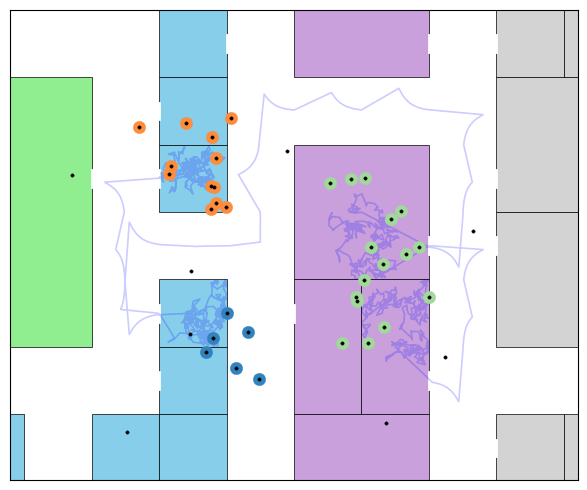

In [22]:
Charlie = Agent(identifier="Charlie",
                home='h-x13-y11',
                workplace='w-x18-y8',
                city=city)

Charlie.generate_trajectory(destination_diary=destinations, seed=1, dt=1/60)
Charlie.sample_trajectory(beta_start=None,
                          beta_durations=None, # <<< default is None, so it could be removed
                          beta_ping=6,
                          seed=2,
                          ha=13/15,
                          replace_sparse_traj=True,
                          deduplicate=True)

dbscan_labels = TADBSCAN._temporal_dbscan_labels(
    data=Charlie.sparse_traj,
    time_thresh=600,
    dist_thresh=0.8,
    min_pts=3,
    dur_min=5,
    traj_cols=traj_cols)

lachesis_labels = LACHESIS._lachesis_labels(
    data=Charlie.sparse_traj,
    dt_max=600,
    delta_roam=2,
    dur_min=5,
    traj_cols=traj_cols)

fig, ax = plt.subplots(figsize=(9, 5))
city.plot_city(ax, doors=True, address=False, zorder=0)

plot_sparse_clusters(Charlie.sparse_traj, dbscan_labels.cluster, ax, full_traj=Charlie.trajectory, buffer=0.5)
plt.savefig("exp1-merging-dbscan.png")

# plot_sparse_clusters(Charlie.sparse_traj, lachesis_labels, ax, full_traj=Charlie.trajectory, buffer=0.5)
# plt.savefig("exp1-merging-lachesis.png")

plt.show()

Set up simulation parameters

In [23]:
BETA_START = [None]
BETA_DUR = [None]
BETA_PING = np.arange(2, 12.5, 0.5).tolist()
ALGOS = ['ta-dbscan', 'lachesis']
HOR_ACC = [3/4]

dbscan_param = dict(time_thresh=600, dist_thresh=0.8, min_pts=3)
lachesis_param = dict(dur_min=5, dt_max=600, delta_roam=2)

N_sim = 100

sim_tasks = list(itertools.product(
    BETA_START,
    BETA_DUR,
    BETA_PING,
    ALGOS,
    HOR_ACC
))
sim_tasks = pd.DataFrame(sim_tasks, columns=['beta_start', 'beta_dur', 'beta_ping', 'algorithm', 'ha'])

agent = Agent(
    identifier="Charlie",
    home='h-x13-y11',
    workplace='w-x18-y8',
    city=city)

In [18]:
%%time

# UNPARALLELIZED CODE

all_metrics_df, metrics_size_df, metrics_btype_df, metrics_dwell_df = run_simulation(
    N=N_sim, 
    epr=False,
    agent=agent,
    destinations=destinations,
    sim_tasks=sim_tasks,
    dt=0.25)

Processing seeds:  25%|██▌       | 25/100 [03:42<11:08,  8.91s/it]

KeyboardInterrupt



In [ ]:
# PARALLELIZED CODE

if __name__ == '__main__':

    dt_val = 0.25
    epr=False
    agent_home='h-x13-y11'
    agent_workplace='w-x18-y8'

    seeds_to_run = range(N_sim)

    # Determine the number of CPU cores to use.
    num_processes = cpu_count()
    print(f"Starting multiprocessing pool with {num_processes} processes.")

    parallel_args = [
        (seed, epr, dt_val, sim_tasks, agent_home, agent_workplace,
         destinations, dbscan_param, lachesis_param, traj_cols, poi_table,
         city, summarize_stops_with_loc)
        for seed in seeds_to_run
    ]

    with Pool(processes=num_processes) as pool:
        results = list(tqdm(pool.starmap(run_simulation_for_single_seed, parallel_args),
                            total=len(parallel_args), desc="Overall Simulation Progress"))

    print("All individual seed simulations completed. Aggregating results...")

    # Initialize empty lists to store results from each simulation
    all_metrics_combined_list = []
    metrics_size_combined_list = []
    metrics_btype_combined_list = []
    metrics_dwell_combined_list = []

    # Unpack and append results from each parallel run
    for res_all_metrics_df, res_metrics_size_df, res_metrics_btype_df, res_metrics_dwell_df in results:
        all_metrics_combined_list.append(res_all_metrics_df)
        metrics_size_combined_list.append(res_metrics_size_df)
        metrics_btype_combined_list.append(res_metrics_btype_df)
        metrics_dwell_combined_list.append(res_metrics_dwell_df)

    # Concatenate all the individual dataframes into final aggregate dataframes
    all_metrics_df = pd.concat(all_metrics_combined_list, ignore_index=True)
    metrics_size_df = pd.concat(metrics_size_combined_list, ignore_index=True)
    metrics_btype_df = pd.concat(metrics_btype_combined_list, ignore_index=True)
    metrics_dwell_df = pd.concat(metrics_dwell_combined_list, ignore_index=True)

    # Create a dictionary to hold all your DataFrames
    all_results = {
        'all_metrics': all_metrics_df,
        'metrics_size': metrics_size_df,
        'metrics_btype': metrics_btype_df,
        'metrics_dwell': metrics_dwell_df
    }

    # Define the filename for your pickle file
    output_filename = 'exp1a_results.pkl'

    # Pickle the dictionary to a file
    with open(output_filename, 'wb') as f:
        pickle.dump(all_results, f)

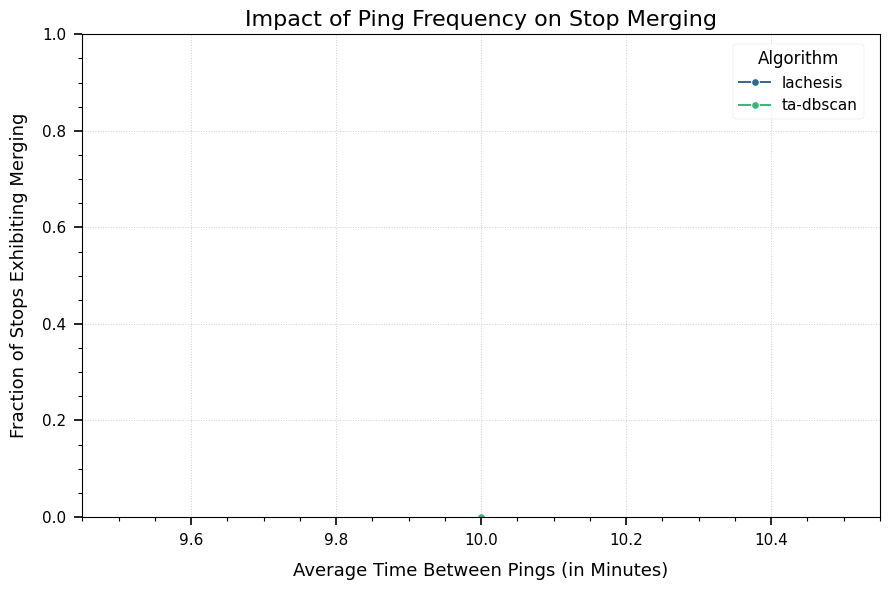

In [35]:
chart_df1 = all_metrics_df.groupby(['beta_ping', 'algorithm'])['merged_fraction'].agg(['mean', 'sem']).reset_index()
chart_df1.rename(columns={'mean': 'merged_fraction_mean', 'sem': 'merged_fraction_sem'}, inplace=True)

fig, ax = plt.subplots(figsize=(9, 6))

sns.lineplot(
    data=chart_df1,
    x='beta_ping',
    y='merged_fraction_mean',
    hue='algorithm',
    marker='o',
    ax=ax,
    errorbar='se',
    palette='viridis'
)

ax.set_title('Impact of Ping Frequency on Stop Merging', fontsize=16)
ax.set_xlabel('Average Time Between Pings (in Minutes)', fontsize=13, labelpad=10)
ax.set_ylabel('Fraction of Stops Exhibiting Merging', fontsize=13, labelpad=10)
ax.legend(title='Algorithm', bbox_to_anchor=(0.98, 0.98), loc='upper right', borderaxespad=0., fontsize=11, title_fontsize=12, frameon=True)

ax.grid(True, linestyle=':', alpha=0.6, linewidth=0.7)
ax.tick_params(axis='both', which='major', labelsize=11, length=6, width=1.2)
ax.tick_params(axis='both', which='minor', length=3, width=0.8)
ax.minorticks_on() 

ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig("merging.png")
plt.savefig("merging.svg")

plt.show()

## Experiment 1.2

Demonstrate splitting: 5 stops of varying areas and dwell times

In [14]:
tz = ZoneInfo("America/New_York")
start_time = pd.date_range(start='2024-06-01 03:00', periods=18, freq='60min', tz=tz)
unix_timestamp = [int(t.timestamp()) for t in start_time]
duration = [60]*18  # in minutes
location = ['h-x13-y6'] * 7 + ['r-x15-y0'] * 1 + ['w-x18-y13'] * 6 + ['r-x18-y5'] * 1 + ['p-x13-y11'] * 3

destinations = pd.DataFrame(
    {"datetime":start_time,
     "timestamp":unix_timestamp,
     "duration":duration,
     "location":location}
     )
destinations = tg.condense_destinations(destinations)

traj_cols = {'user_id':'identifier',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp'}

Example plot

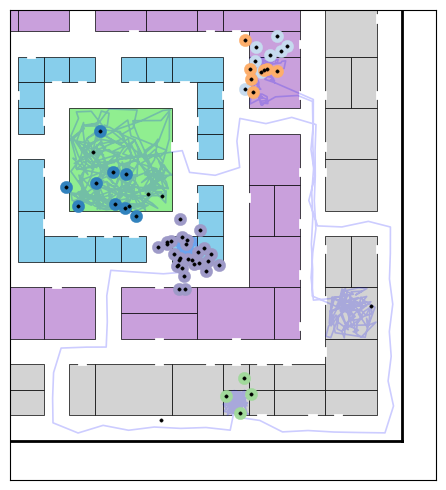

In [15]:
algo = 'ta-dbscan'  # or 'lachesis'

Charlie = Agent(identifier="Charlie",
                home='h-x13-y11',
                workplace='w-x18-y8',
                city=city)

Charlie.generate_trajectory(destination_diary=destinations, dt=0.25, seed=300)
Charlie.sample_trajectory(*(20, 45, 10), seed=300, replace_sparse_traj=True)

if algo == 'ta-dbscan':
    labels = TADBSCAN._temporal_dbscan_labels(
        data=Charlie.sparse_traj,
        time_thresh=90,
        dist_thresh=2,
        min_pts=2,
        traj_cols=traj_cols)
    
elif algo == 'lachesis':
    labels = LACHESIS._lachesis_labels(
        data=Charlie.sparse_traj,
        dt_max=20,
        delta_roam=75,
        dur_min=2,
        traj_cols=traj_cols)
    
labels.name = 'cluster'
sparse_with_cluster = Charlie.sparse_traj.join(labels)

pred = visits.point_in_polygon(
    data=sparse_with_cluster,
    poi_table=poi_table,
    method='majority',
    data_crs='EPSG:4326',
    max_distance=15,
    cluster_label='cluster',
    location_id='building_id',
    x='x',
    y='y')

pred = sparse_with_cluster.join(pred)
stops = pred[pred.cluster!=-1].groupby('cluster', as_index=False).apply(summarize_stops_with_loc, include_groups=False)

fig, ax = plt.subplots(figsize=(9, 5))
city.plot_city(ax, doors=True, address=False, zorder=0)

plot_sparse_clusters(Charlie.sparse_traj, 
                     labels.cluster, 
                     ax,
                     full_traj=Charlie.trajectory, 
                     buffer=0.25)

# plt.savefig("exp2-splitting-dbscan.png")
plt.show()

In [16]:
BETA_START = np.arange(10, 200, 10).tolist()
BETA_DUR = [45]
BETA_PING = [10]
ALGOS = ['ta-dbscan', 'lachesis']
HOR_ACC = [3/4]

dbscan_param = dict(time_thresh=90, dist_thresh=1.2, min_pts=2)
lachesis_param = dict(dur_min=5, dt_max=90, delta_roam=2)

N_sim = 10

sim_tasks = list(itertools.product(
    BETA_START,
    BETA_DUR,
    BETA_PING,
    ALGOS,
    HOR_ACC
))
sim_tasks = pd.DataFrame(sim_tasks, columns=['beta_start', 'beta_dur', 'beta_ping', 'algorithm', 'ha'])

agent = Agent(
    identifier="Charlie",
    home='h-x13-y11',
    workplace='w-x18-y8',
    city=city)

In [29]:
%%time

# UNPARALLELIZED CODE

all_metrics_df, metrics_size_df, metrics_btype_df, metrics_dwell_df = run_simulation(
    N=N_sim, 
    epr=False,
    agent=agent,
    destinations=destinations,
    sim_tasks=sim_tasks, 
    dt=0.25)

Processing seeds: 100%|██████████| 10/10 [01:26<00:00,  8.68s/it]

CPU times: user 1min 26s, sys: 10.2 ms, total: 1min 26s
Wall time: 1min 26s


In [ ]:
# PARALLELIZED CODE

if __name__ == '__main__':

    dt_val = 0.25
    epr=False
    agent_home='h-x13-y11'
    agent_workplace='w-x18-y8'

    seeds_to_run = range(N_sim)

    # Determine the number of CPU cores to use.
    num_processes = cpu_count()
    print(f"Starting multiprocessing pool with {num_processes} processes.")

    parallel_args = [
        (seed, epr, dt_val, sim_tasks, agent_home, agent_workplace,
         destinations, dbscan_param, lachesis_param, traj_cols, poi_table,
         city, summarize_stops_with_loc)
        for seed in seeds_to_run
    ]

    with Pool(processes=num_processes) as pool:
        results = list(tqdm(pool.starmap(run_simulation_for_single_seed, parallel_args),
                            total=len(parallel_args), desc="Overall Simulation Progress"))

    print("All individual seed simulations completed. Aggregating results...")

    # Initialize empty lists to store results from each simulation
    all_metrics_combined_list = []
    metrics_size_combined_list = []
    metrics_btype_combined_list = []
    metrics_dwell_combined_list = []

    # Unpack and append results from each parallel run
    for res_all_metrics_df, res_metrics_size_df, res_metrics_btype_df, res_metrics_dwell_df in results:
        all_metrics_combined_list.append(res_all_metrics_df)
        metrics_size_combined_list.append(res_metrics_size_df)
        metrics_btype_combined_list.append(res_metrics_btype_df)
        metrics_dwell_combined_list.append(res_metrics_dwell_df)

    # Concatenate all the individual dataframes into final aggregate dataframes
    all_metrics_df = pd.concat(all_metrics_combined_list, ignore_index=True)
    metrics_size_df = pd.concat(metrics_size_combined_list, ignore_index=True)
    metrics_btype_df = pd.concat(metrics_btype_combined_list, ignore_index=True)
    metrics_dwell_df = pd.concat(metrics_dwell_combined_list, ignore_index=True)

    # Create a dictionary to hold all your DataFrames
    all_results = {
        'all_metrics': all_metrics_df,
        'metrics_size': metrics_size_df,
        'metrics_btype': metrics_btype_df,
        'metrics_dwell': metrics_dwell_df
    }

    # Define the filename for your pickle file
    output_filename = 'exp1b_results.pkl'

    # Pickle the dictionary to a file
    with open(output_filename, 'wb') as f:
        pickle.dump(all_results, f)

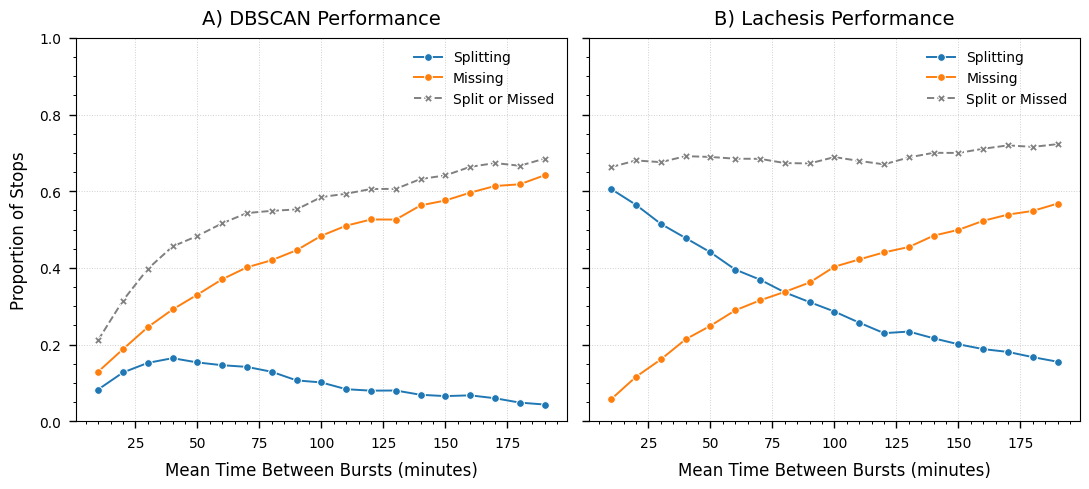

In [20]:
# Calculate mean and standard error of the mean for each metric
chart_df2 = all_metrics_df.groupby(['beta_start', 'algorithm']).agg(
    split_fraction_mean=('split_fraction', 'mean'),
    split_fraction_sem=('split_fraction', 'sem'),
    missed_fraction_mean=('missed_fraction', 'mean'),
    missed_fraction_sem=('missed_fraction', 'sem')
).reset_index()

chart_df2['both_mean'] = chart_df2['split_fraction_mean'] + chart_df2['missed_fraction_mean']
chart_df2['both_sem'] = (chart_df2['split_fraction_sem']**2 + chart_df2['missed_fraction_sem']**2)**0.5

chart_df2_dbscan = chart_df2[chart_df2.algorithm == 'ta-dbscan']
chart_df2_lachesis = chart_df2[chart_df2.algorithm == 'lachesis']

# --- Charting ---
fig, axes = plt.subplots(1, 2, figsize=(11, 5), sharey=True)
colors = sns.color_palette("tab10", n_colors=3)

# Plot for DBSCAN (Left Subplot)
sns.lineplot(
    data=chart_df2_dbscan,
    x='beta_start',
    y='split_fraction_mean',
    ax=axes[0],
    label='Splitting',
    marker='o',
    color=colors[0],
    errorbar='se'
)
sns.lineplot(
    data=chart_df2_dbscan,
    x='beta_start',
    y='missed_fraction_mean',
    ax=axes[0],
    label='Missing',
    marker='o',
    color=colors[1],
    errorbar='se'
)
sns.lineplot(
    data=chart_df2_dbscan,
    x='beta_start',
    y='both_mean',
    ax=axes[0],
    label='Split or Missed',
    linestyle='--',
    color='gray',
    marker='X',
    errorbar='se'
)

axes[0].set_title('A) DBSCAN Performance', fontsize=14, pad=10) 
axes[0].set_xlabel('Mean Time Between Bursts (minutes)', fontsize=12, labelpad=8)
axes[0].set_ylabel('Proportion of Stops', fontsize=12, labelpad=8)
axes[0].legend(fontsize=10, frameon=False) # Removed frame
axes[0].grid(True, linestyle=':', alpha=0.6, linewidth=0.7)
axes[0].tick_params(axis='both', which='major', labelsize=10, length=5, width=1)
axes[0].minorticks_on()
axes[0].tick_params(axis='both', which='minor', length=2.5, width=0.7)
axes[0].set_ylim(0, 1)

# Plot for Lachesis (Right Subplot)
sns.lineplot(
    data=chart_df2_lachesis,
    x='beta_start',
    y='split_fraction_mean',
    ax=axes[1],
    label='Splitting',
    marker='o',
    color=colors[0],
    errorbar='se'
)
sns.lineplot(
    data=chart_df2_lachesis,
    x='beta_start',
    y='missed_fraction_mean',
    ax=axes[1],
    label='Missing',
    marker='o',
    color=colors[1],
    errorbar='se'
)
sns.lineplot(
    data=chart_df2_lachesis,
    x='beta_start',
    y='both_mean',
    ax=axes[1],
    label='Split or Missed',
    linestyle='--',
    color='gray',
    marker='X',
    errorbar='se'
)
axes[1].set_title('B) Lachesis Performance', fontsize=14, pad=10) 
axes[1].set_xlabel('Mean Time Between Bursts (minutes)', fontsize=12, labelpad=8)
axes[1].legend(fontsize=10, frameon=False)
axes[1].grid(True, linestyle=':', alpha=0.6, linewidth=0.7)
axes[1].tick_params(axis='both', which='major', labelsize=10, length=5, width=1)
axes[1].minorticks_on()
axes[1].tick_params(axis='both', which='minor', length=2.5, width=0.7)
axes[1].set_ylim(0, 1) # Proportions

plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig("split-missed-comparison.png", dpi=300, bbox_inches='tight')
plt.savefig("split-missed-comparison.svg", bbox_inches='tight')

plt.show()

## Experiment 2

3 weeks of realistic trajectories

In [8]:
def gen_params_target_q(N, q_range=(0.3, 0.9), beta_dur_range=(25, 240), seed=None):
    rng = npr.default_rng(seed)
    params = []
    for _ in range(N):
        c = rng.uniform(*q_range)
        beta_durations = rng.uniform(*beta_dur_range)
        beta_start = beta_durations / c
        beta_ping = min(
            (rng.uniform(2, 8) if rng.random() < 0.5 else rng.uniform(22, 28)),
            beta_durations
        )
        params.append([beta_start, beta_durations, beta_ping])
    return np.array(params)

In [13]:
N_agents = 100
N_sim = 30  # per agent

ALL_BETAS = gen_params_target_q(N=N_agents, q_range=(0.4, 0.85), seed=1)
HOR_ACCS = np.random.uniform(10/15, 16/15, size=N_agents)
agent_id = list(range(1, N_agents+1))
sim_tasks = np.column_stack([agent_id, ALL_BETAS, HOR_ACCS])

sim_tasks = pd.DataFrame(
    np.repeat(sim_tasks, 2, axis=0),
    columns=['agent', 'beta_start', 'beta_dur', 'beta_ping', 'ha']
)
sim_tasks['algorithm'] = ['ta-dbscan', 'lachesis'] * N_agents

dbscan_param = dict(time_thresh=600, dist_thresh=0.8, min_pts=3)
lachesis_param = dict(dur_min=5, dt_max=600, delta_roam=2)

traj_cols = {'user_id':'identifier',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp'}

In [ ]:
%%time

all_metrics_df, metrics_size_df, metrics_btype_df, metrics_dwell_df = run_simulation(
    N=N_agents, 
    epr=True,
    sim_tasks=sim_tasks,
    dt=0.25)

In [14]:
# --- Main execution block in your SageMaker notebook ---
if __name__ == '__main__':

    dt_val = 0.25
    epr=True
    agent_home=None
    agent_workplace=None
    destinations=None

    seeds_to_run = range(1, N_agents+1)

    # Determine the number of CPU cores to use.
    num_processes = cpu_count()
    print(f"Starting multiprocessing pool with {num_processes} processes.")

    parallel_args = [
        (seed, epr, dt_val, sim_tasks, agent_home, agent_workplace,
         destinations, dbscan_param, lachesis_param, traj_cols, poi_table,
         city, summarize_stops_with_loc)
        for seed in seeds_to_run
    ]

    with Pool(processes=num_processes) as pool:
        results = list(tqdm(pool.starmap(run_simulation_for_single_seed, parallel_args),
                            total=len(parallel_args), desc="Overall Simulation Progress"))

    print("All individual seed simulations completed. Aggregating results...")

    # Initialize empty lists to store results from each simulation
    all_metrics_combined_list = []
    metrics_size_combined_list = []
    metrics_btype_combined_list = []
    metrics_dwell_combined_list = []

    # Unpack and append results from each parallel run
    for res_all_metrics_df, res_metrics_size_df, res_metrics_btype_df, res_metrics_dwell_df in results:
        all_metrics_combined_list.append(res_all_metrics_df)
        metrics_size_combined_list.append(res_metrics_size_df)
        metrics_btype_combined_list.append(res_metrics_btype_df)
        metrics_dwell_combined_list.append(res_metrics_dwell_df)

    # Concatenate all the individual dataframes into final aggregate dataframes
    all_metrics_df = pd.concat(all_metrics_combined_list, ignore_index=True)
    metrics_size_df = pd.concat(metrics_size_combined_list, ignore_index=True)
    metrics_btype_df = pd.concat(metrics_btype_combined_list, ignore_index=True)
    metrics_dwell_df = pd.concat(metrics_dwell_combined_list, ignore_index=True)

    # Create a dictionary to hold all your DataFrames
    all_results = {
        'all_metrics': all_metrics_df,
        'metrics_size': metrics_size_df,
        'metrics_btype': metrics_btype_df,
        'metrics_dwell': metrics_dwell_df
    }

    # Define the filename for your pickle file
    output_filename = 'exp2_results.pkl'

    # Pickle the dictionary to a file
    with open(output_filename, 'wb') as f:
        pickle.dump(all_results, f)

Starting multiprocessing pool with 48 processes.
Running simulation for seed 1 on process 8506
Running simulation for seed 2 on process 8507
Running simulation for seed 3 on process 8508
Running simulation for seed 4 on process 8509
Running simulation for seed 5 on process 8510
Running simulation for seed 6 on process 8515
Running simulation for seed 7 on process 8517
Running simulation for seed 8 on process 8521
Running simulation for seed 9 on process 8523
Running simulation for seed 10 on process 8524
Running simulation for seed 11 on process 8525
Running simulation for seed 12 on process 8526
Running simulation for seed 13 on process 8527
Running simulation for seed 14 on process 8528
Running simulation for seed 15 on process 8529
Running simulation for seed 16 on process 8530
Running simulation for seed 17 on process 8531
Running simulation for seed 18 on process 8535
Running simulation for seed 19 on process 8536
Running simulation for seed 20 on process 8537
Running simulation f

Process ForkPoolWorker-41:
Process ForkPoolWorker-42:
Process ForkPoolWorker-26:
Process ForkPoolWorker-47:
Process ForkPoolWorker-18:
Process ForkPoolWorker-25:
Process ForkPoolWorker-48:
Process ForkPoolWorker-33:
Process ForkPoolWorker-11:
Process ForkPoolWorker-8:
Process ForkPoolWorker-38:
Process ForkPoolWorker-43:
Process ForkPoolWorker-28:
Process ForkPoolWorker-37:
Process ForkPoolWorker-39:
Process ForkPoolWorker-45:
Process ForkPoolWorker-40:
Process ForkPoolWorker-12:
Process ForkPoolWorker-29:
Process ForkPoolWorker-44:
Process ForkPoolWorker-35:
Process ForkPoolWorker-16:
Process ForkPoolWorker-24:
Process ForkPoolWorker-17:
Process ForkPoolWorker-31:
Process ForkPoolWorker-23:
Process ForkPoolWorker-15:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-46:
Traceback (most recent call last):
Traceback (most recent call last):


KeyboardInterrupt: 

In [15]:
all_metrics_df

NameError: name 'all_metrics_df' is not defined

TODO:
- add oracle

exp2 (3 weeks of realistic trajectories): three x-axes, using target q sampler
- q
- noise
- maybe beta_ping if interesting
- maybe bring back coarse, fine

## Methodology

- We explain garden city and how we produced ground truth, heavily referencing the Arxiv version
- We divide in three sections after that
- Possible problems in stop detection
- Are these problems present in real (global) trajectories? + covariates
- Can the parameterizations address these issues?

There are regimes in which certain problems disappear.
- E.g. going from extremely complete signals to very complete signals, might not make a difference in terms of quality---they are both good enough. This analysis could be visualized in a plot with q in the x-axis, showing that for high q and very low q things break down. 
- E.g. a very bad parameterization of DBScan for retail, might obscure a small effect of beta ping on retail. 
- Some problems might mostly affect users that explore a lot (this is application-relevant). 
- Maybe the conclusion is that you need a hierarchical DBScan

We show problems. Can we THEN show solutions? Then maybe we can hint at solutions while describing problems. 

## Global problems

Related to the intensity and clustering of the bursts. It can affect if stops are missed (recall), it can also mess with accuracy by building type (typically long/short dwells).

- Missingness is more severe for home and work compared to retail and park. Maybe a ratio statistic alongside the magnitude decreases. Pick a "reasonable" DBScan (based on recall). Parameters of a typical user in a typical dataset (avoid a regime where nothing/everything works). 
- Obvious plot is you have less signal (gray rectangles) then you miss more stops/time-at-right-stop overall. Show regimes? Specially for exploration-prone users? + nuance.

## Parameterization problems

You can truly choose the wrong parameters, and you might want to incorporate user signal parameters and building areas, and whatnot. Quality of algorithms and how to choose. x-axis is parameter of DBScan and y-axis is quality of clusters.
- What would you do with a complete and regular signal? Maybe a "reasonable" DBScan would fail miserably and Lachesis would succeed? min_pts would save the day? 
- Time parameter ranges from 1 hour to 16 hours. Long-dwell "bridging" of huge gaps would increase (obviously) but, the nuance is overestimating time at work or at home. Absolute vs Relative. 
- Epsilon affects splitting and merging. Pick a "default and reasonable" beta_ping and change epsilon. 